Population according to regions and buses

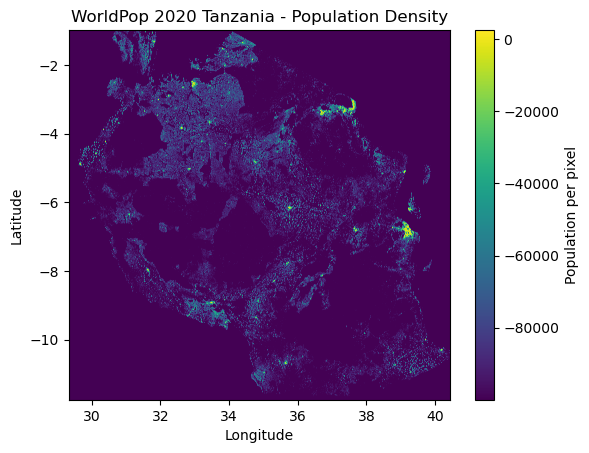

In [1]:
import rasterio
import matplotlib.pyplot as plt

tif_path = r"C:/Users/hie/pe_tan/pypsa-earth/data/WorldPop/tza_ppp_2020_UNadj_constrained.tif"

with rasterio.open(tif_path) as src:
    population = src.read(1)  # first (and only) band
    extent = [src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top]

plt.imshow(population, cmap='viridis', extent=extent)
plt.colorbar(label='Population per pixel')
plt.title('WorldPop 2020 Tanzania - Population Density')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()


Accurate population/region based on gadm shape.

Total population from GADM shapes: 59719273.40800086


KeyError: 'Region'

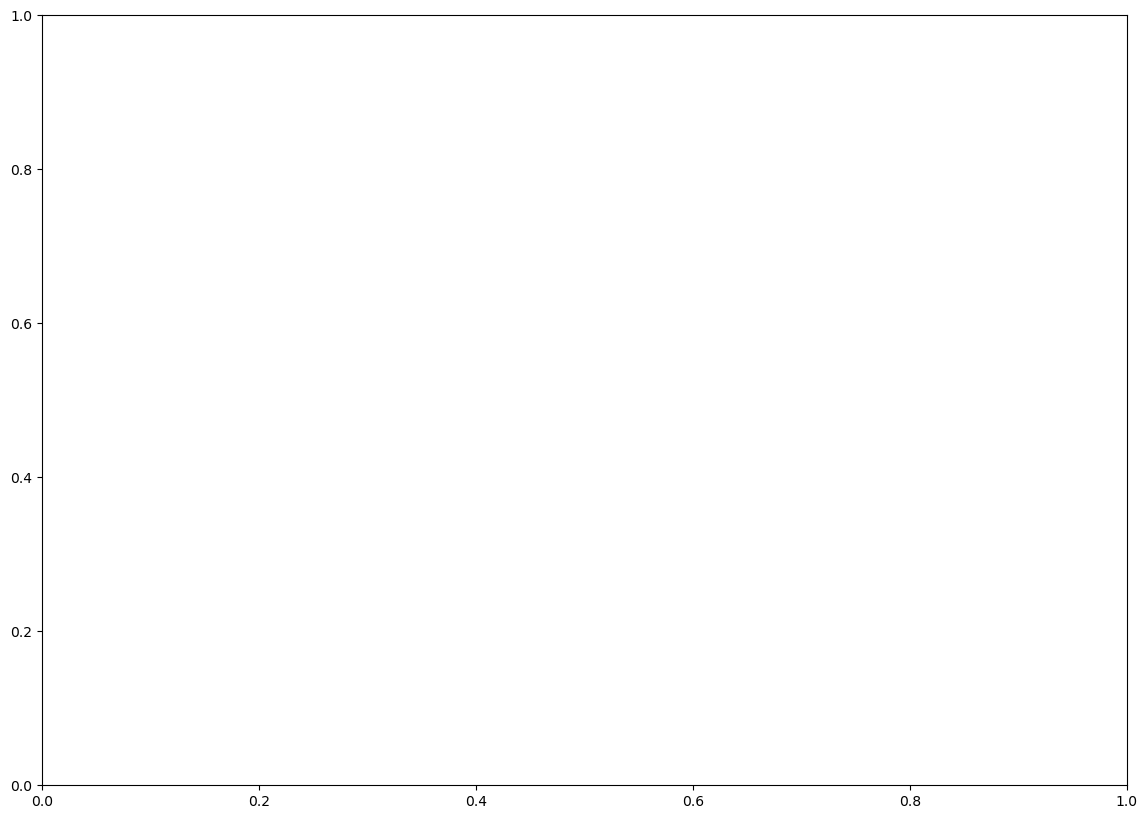

In [38]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt


# Load GADM shapes with population and GDP and names
gadm_shapes = gpd.read_file("C:/Users/hie/pe_tan/pypsa-earth/resources/shapes/gadm_shapes.geojson")
gadm_shapes = gadm_shapes.to_crs("EPSG:4326")

# Extract only the required fields
matched_df = gadm_shapes[["GADM_ID", "NAME_1", "pop"]].copy()
matched_df.rename(columns={"pop": "Population", "NAME_1": "Region"}, inplace=True)

# Save to CSV
#matched_df.to_csv("C:/Users/hie/pe_tan/pypsa-earth/Script_analysis/matched_population_by_region.csv", index=False)

# Define pop_by_region
pop_by_region = matched_df.groupby(["GADM_ID", "Region"], as_index=False).sum()

# Calculate total population
total_population = pop_by_region["Population"].sum()
print(f"Total population from GADM shapes: {total_population}")

# Plot the population per region
fig, ax = plt.subplots(figsize=(14, 10))

# Merge population data with geometries
pop_plot = gadm_shapes.merge(pop_by_region, on=["GADM_ID", "Region"])
pop_plot.plot(column="Population", cmap="viridis", legend=True, ax=ax, edgecolor="black")

# Add region names to the plot
for _, row in pop_by_region.iterrows():
    region_geom = gadm_shapes[gadm_shapes["Region"] == row["Region"]].geometry.values[0]
    centroid = region_geom.centroid
    ax.text(centroid.x, centroid.y, row["Region"], fontsize=8, ha="center")

plt.title("Population per Region in Tanzania 2020")
plt.axis("off")
plt.tight_layout()
plt.show()

In [6]:
import pypsa

path_old="C:/Users/hie/pe_tan/pypsa-earth/results/networks/elec_s_25_ec_lcopt_Co2L-24h.nc"
network_old = pypsa.Network(path_old)

# Plot the network
network_old.iplot(mapbox='osm')


INFO:pypsa.io:Imported network elec_s_25_ec_lcopt_Co2L-24h.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


{'data': [Scattermapbox({
      'lat': [-7.7772, -7.7772],
      'line': {'color': 'darkseagreen', 'width': 3},
      'lon': [37.8406, 37.8406],
      'mode': 'lines',
      'opacity': 0.8
  }),
  Scattermapbox({
      'lat': [-1.78215, -1.78215],
      'line': {'color': 'darkseagreen', 'width': 3},
      'lon': [33.84715, 33.84715],
      'mode': 'lines',
      'opacity': 0.8
  }),
  Scattermapbox({
      'lat': [-4.56445, -4.56445],
      'line': {'color': 'darkseagreen', 'width': 3},
      'lon': [35.7672, 35.7672],
      'mode': 'lines',
      'opacity': 0.8
  }),
  Scattermapbox({
      'lat': [-7.6672, -7.6672],
      'line': {'color': 'darkseagreen', 'width': 3},
      'lon': [36.974, 36.974],
      'mode': 'lines',
      'opacity': 0.8
  }),
  Scattermapbox({
      'lat': [-7.1387, -7.1387],
      'line': {'color': 'darkseagreen', 'width': 3},
      'lon': [35.9892, 35.9892],
      'mode': 'lines',
      'opacity': 0.8
  }),
  Scattermapbox({
      'lat': [-2.6887, -2.6887],
  

In [8]:
import pypsa

path_old="C:/Users/hie/pe_tan/pypsa-earth/networks/base.nc"
network_old = pypsa.Network(path_old)

# Plot the network
network_old.iplot(mapbox='osm')


INFO:pypsa.io:Imported network base.nc has buses, lines, transformers


{'data': [Scattermapbox({
      'lat': [-6.7116, -6.6391],
      'line': {'color': 'rosybrown', 'width': 3},
      'lon': [38.7439, 38.3571],
      'mode': 'lines',
      'opacity': 0.8
  }),
  Scattermapbox({
      'lat': [-5.298, -4.0717],
      'line': {'color': 'rosybrown', 'width': 3},
      'lon': [38.6148, 37.7377],
      'mode': 'lines',
      'opacity': 0.8
  }),
  Scattermapbox({
      'lat': [-4.8406, -3.6219],
      'line': {'color': 'rosybrown', 'width': 3},
      'lon': [34.7563, 33.5148],
      'mode': 'lines',
      'opacity': 0.8
  }),
  Scattermapbox({
      'lat': [-8.8482, -8.9146],
      'line': {'color': 'rosybrown', 'width': 3},
      'lon': [34.8061, 33.4967],
      'mode': 'lines',
      'opacity': 0.8
  }),
  Scattermapbox({
      'lat': [-3.6219, -3.2208],
      'line': {'color': 'rosybrown', 'width': 3},
      'lon': [33.5148, 32.4905],
      'mode': 'lines',
      'opacity': 0.8
  }),
  Scattermapbox({
      'lat': [-3.861, -3.6219],
      'line': {'color':